# Chapter 8 Notes

## 8.2 The Bootstrap and Maximum Likelihood Methods

### 8.2.1 A Smoothing Example

Suppose that we have one dimensional data $\mathbb{Z}=\lbrace z_1, \ldots, z_N\rbrace$ where $z_i=(x_i, y_i)$.
We might fit a curve to this using cubic splines with knots at quantiles of the $x$-values.
Since this is just a linear model we can generate (pointwise) confidence bands around our estimate (see §3.2 for details).

We can also generate confidence bands using bootstrapping.
We consider two different versions.

**Non-parametric bootstrap:**
Draw bootstrap samples with replacement from the $z_i$.
For each boostrap sample fit a cubic spline to the data.
Generate a confidence interval at each $x$ by taking percentiles of bootstrap splines evaluated at the point.

*Note:* There is a decision here whether to use the original knots or generate new knots using the bootstrapped $x$-values.
This choice depends on whether we want to capture the variability from the position of the knots as well as the noise in the targets.
The flexibility of the method means that we could even use more complex methods for choosing the number and position of the knots.

**Parametric boostrap:**
Fit cubic splines to the original training data and then simulate new responses by adding Gaussian noise to the predicted values.
That is, if $\mu(x)$ is our spline function, sample $y_i^* \sim \mathcal{N}(\mu(x_i), \hat{\sigma}^2)$, where $\hat{\sigma}$ is the sample variance of the $y_i$. We then construct our boostrapped splines by fitting to the new $(x_i, y_i^*)$. Again, we can construct pointwise confidence intervals by taking percentiles of the bootstrapped splines.

In this case, the confidence intervals agree with those generated through the least squares estimate at the start.
In general the parametric boostrap agrees with maximum likelihood.

### 8.2.2 Maximum Likelihood Inference

If we specify a parametric model for $Z$ via a probability density function $z \sim g_{\theta}(z)$ then we can calculate the maximum likelihood estimator $\hat{\theta}$ for the parameters $\theta$.
The sampling distribution of the MLE has a limiting Normal distribution:

\begin{equation}
    \hat{\theta} \longrightarrow \mathcal{N}\left( \theta_0, \mathbf{i}(\theta_0)^{-1}\right),
\end{equation}

where $\mathbf{i}(\theta)$ is the Fisher information and $\theta_0$ is the true parameter value.
Using $\hat{\theta}$ to approximate $\hat{theta}_0$, this allows us to construct approximate confidence intervals around the MLE, which we can then use to get pointwise confidence intervals.

## 8.3 Bayesian Methods

We can alternatively generate Bayesian credible intervals by putting priors on the spline coefficients (and variance).
The text shows that if the spline coefficients are uncorrelated in prior, then the Bayesian intervals approach the parametric boostrap and maximum likelihood as the variance of the priors increase; that is, as they tend towards a non-informative prior.

## 8.4 Relationship Between the Bootstrap and Bayesian Inference

They show that for a Bernoulli sample with $\alpha$ successes and $\beta$ failures, the Bayesian posterior $\text{Beta}(\alpha, \beta)$ that results from an  uninformative prior is almost the same as the boostrap distribution of the estimator for the true success probability.
This generalises to a Multinomial distribution using the Dirichlet distribution instead of the Beta distribution.

In this sense the bootstrap distribution represents an approximate non-parametric, uninformative posterior distribution for our parameter.



## 8.5 The EM Algorithm

The Expectation-Maximization algorithm is a general method for simplifying difficult maximum likelihood problems by enlarging the sample with latent data.

### 8.5.1 Two-Component Mixture Model

In [5]:
import numpy as np
import pandas as pd

In [6]:
data = np.array([
    -0.39, 0.12, 0.94, 1.67, 1.76, 2.44, 3.72, 4.28, 4.92, 5.53,
     0.06, 0.48, 1.01, 1.68, 1.80, 3.25, 4.12, 4.60, 5.28, 6.22
])

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def em_gmm(data, n_components=2, max_iter=100, tol=1e-6):
    # Initialize parameters
    n = len(data)
    # Simple initialization using data min/max
    mu = np.array([data.min(), data.max()])
    sigma = np.array([1.0, 1.0])
    mixing_coefficients = np.array([0.5, 0.5])
    
    log_likelihood_history = []
    
    for iteration in range(max_iter):
        # E-step: compute responsibilities
        resp = np.zeros((n, n_components))
        for k in range(n_components):
            resp[:, k] = mixing_coefficients[k] * norm.pdf(data, mu[k], sigma[k])
        resp = resp / resp.sum(axis=1, keepdims=True)
        
        # M-step: update parameters
        Nk = resp.sum(axis=0)
        
        # Update means
        mu_new = np.array([np.sum(resp[:, k] * data) / Nk[k] for k in range(n_components)])
        
        # Update variances and standard deviations
        variance_new = np.array([np.sum(resp[:, k] * (data - mu_new[k])**2) / Nk[k] 
                             for k in range(n_components)])
        sigma_new = np.sqrt(variance_new)
        
        # Update mixing coefficients
        mixing_coefficients_new = Nk / n
        
        # Compute log likelihood
        log_likelihood = np.sum(np.log(np.sum([mixing_coefficients[k] * norm.pdf(data, mu[k], sigma[k]) 
                                   for k in range(n_components)], axis=0)))
        log_likelihood_history.append(log_likelihood)
        
        # Check convergence
        if iteration > 0:
            if abs(log_likelihood_history[-1] - log_likelihood_history[-2]) < tol:
                break
        
        # Update parameters
        mu, sigma, mixing_coefficients = mu_new, sigma_new, mixing_coefficients_new
    
    return mu, sigma, mixing_coefficients, log_likelihood_history

<Figure size 1200x600 with 0 Axes>

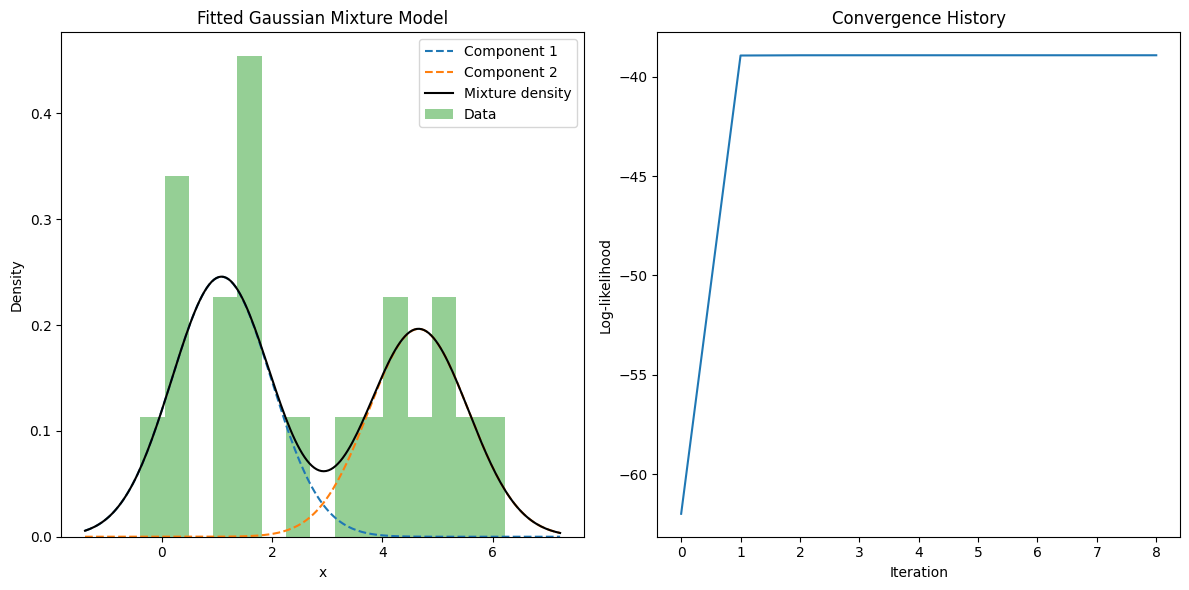

Final parameters:
Component 1:
  Mean: 1.08
  Standard deviation: 0.90
  Mixing coefficient: 0.55
Component 2:
  Mean: 4.66
  Standard deviation: 0.91
  Mixing coefficient: 0.45


In [ ]:
def plot_mixture_model(data, mu, sigma, mixing_coefficients):
    """Plot the fitted Gaussian mixture model components and data histogram."""
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Data and fitted components
    plt.subplot(1, 2, 1)
    x = np.linspace(data.min() - 1, data.max() + 1, 200)
    
    # Plot individual components
    for k in range(2):
        component = mixing_coefficients[k] * norm.pdf(x, mu[k], sigma[k])
        plt.plot(x, component, '--', label=f'Component {k+1}')
    
    # Plot mixture density
    mixture = sum(mixing_coefficients[k] * norm.pdf(x, mu[k], sigma[k]) for k in range(2))
    plt.plot(x, mixture, 'k-', label='Mixture density')
    
    # Plot data points
    plt.hist(data, density=True, alpha=0.5, bins=15, label='Data')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Fitted Gaussian Mixture Model')
    plt.legend()
    
def plot_convergence_history(history):
    """Plot the convergence history of the EM algorithm."""
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.xlabel('Iteration')
    plt.ylabel('Log-likelihood')
    plt.title('Convergence History')
    
def print_model_parameters(mu, sigma, mixing_coefficients):
    """Print the final parameters of the fitted model."""
    print('Final parameters:')
    for k in range(2):
        print(f'Component {k+1}:')
        print(f'  Mean: {mu[k]:.3f}')
        print(f'  Standard deviation: {sigma[k]:.3f}')
        print(f'  Mixing coefficient: {mixing_coefficients[k]:.3f}')

# Fit the model
mu, sigma, mixing_coefficients, history = em_gmm(data)

# Create visualization
plt.figure(figsize=(12, 6))
plot_mixture_model(data, mu, sigma, mixing_coefficients)
plot_convergence_history(history)
plt.tight_layout()
plt.show()

# Print the results
print_model_parameters(mu, sigma, mixing_coefficients)